# Exploratory Data Analysis - US Equities Fundamentals 

In my effort to learn the basic skills needed for a career as a data scientist, I needed to practice with a data set that I found personally interesting. I've previously investigated college admissions data, which was directly related to my previous work with Newton. But for this project I decided to dive into the stock market so I could start to understand a small slice of the world my good friend in finance is always trying to talk with me about. 

I discovered Quandl, a company that collects and sells data for use in making investment decisions. Some of their data is available for free when you create an account and they will provide you an API key and python library to access their data.  I decided their _[SF1 Core US Fundamentals Data](https://www.quandl.com/data/SF1-Core-US-Fundamentals-Data)_ would help me better understand the shape and scale of the equities market. This dataset contains one entry per company for each of the last seven years with over one hundred indicators (columns) showing not only basic balance sheet information like total company assets and liabilities but also dozens of more esoteric indicators that I can at this point only barely understand.

In addition to this indicators table, there is a tickers table which includes one entry for each company, indexed by their stock ticker, with columns containing information like the full company name, sector, industry, location, which exchange the company is listed, and so forth. For our purposes, we will need to use both tables.

---
## Get the tickers

Quandl provides tickers information in a .txt file on its website. We'll import it to a pandas dataframe and save it to a postgreSQL database, and then take a look at how many tickers we have by sector:

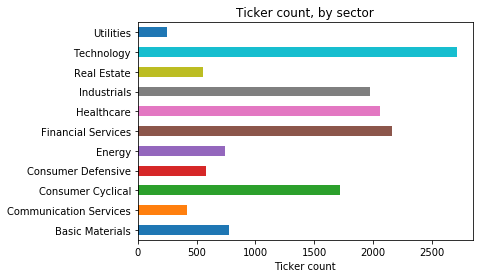

In [12]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Create engine for connecting to a previously created empty database
engine = create_engine('postgresql:///fundamentals')

# Import the ticker data set from Sharadar into a DataFrame
tickers_data = pd.read_csv('http://www.sharadar.com/meta/tickers.txt', 
                           sep='\t', true_values='Y', false_values='N',
                           parse_dates=['First Added','Last Updated'])

# Reformat column headings 
tickers_data.columns = [x.lower().replace(' ', '_') for x in tickers_data.columns]

# Convert one of the date columns with sparse data to a DateTime type with NaT for 
tickers_data['ticker_change_date'] = pd.to_datetime(tickers_data['ticker_change_date'], errors="coerce")

# Write tickers_data to the database.
tickers_data.to_sql(name = 'tickers_data', con=engine, if_exists='replace', index=False)

tickers_data.set_index('ticker', inplace=True)

tickers_data.groupby('sector').size().plot(kind='barh')
plt.title('Ticker count, by sector')
plt.xlabel('Ticker count')
plt.ylabel('')
plt.show()

We've got a lot of tickers, from a vareity of sectors. We can see there are definitely fewer listed utilities companies, and a ton of technology companies.

---
## Examining the indicators table
Let's use the quandl API to get the indicators:


In [2]:
# Import the quandl library to request indicators
import quandl

# Supply quandl a personal api_key, which requires registration
quandl.ApiConfig.api_key = 'xTnbzz5kmyEnGT-fGvt4'

# Get the list of tickers to request from our existing Tickers table
tickers_list = tickers_data.index.tolist()

# Free users of quandl are only able to request end of year data for the last seven years
dates_list = ['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31']

# There seems to be a limit to the number of tickers that can be requested at once.
# In order to request the much larger indicators dataset from Quandl, I need to supply a list of tickers and dates. 
# I might as well grab all the data we can. So I'll make a list of all the tickers from the tickers_data dataframe. 
# Then I'll request ticker indicators in chunks and save each chunk to one table in our database.

step = 400
for start in range(0, len(tickers_list), step):
    if start + step < len(tickers_list):
        request_tickers = tickers_list[start:start+step-1]
    else:
        request_tickers = tickers_list[start:]
    
    returned_indicators = quandl.get_table('SHARADAR/SF1',
                                            calendardate = dates_list,
                                            ticker = request_tickers)
    
    returned_indicators.to_sql(name = 'indicators_data',
                               con = engine,
                               if_exists = 'append',
                               index = False)

# Count all the rows we just imported.
pd.read_sql("SELECT COUNT(*) FROM indicators_data;", con=engine)

,count
0,40842


Quandl gave us 40,842 rows of indicators data. Bear in mind that there could be up to seven entries for a single ticker, one for each year that ticker may be listed. Let's look at the marketcaps for the AAPL ticker the past seven years:

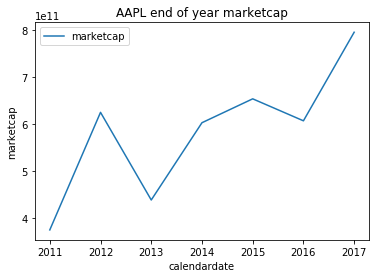

In [24]:
sql = "SELECT marketcap, calendardate FROM indicators_data WHERE ticker LIKE 'AAPL';"
result = pd.read_sql(sql, index_col = 'calendardate', con = engine)
result.plot()
plt.title('AAPL end of year marketcap')
plt.ylabel('marketcap')
plt.show()

The `marketcap` is just one of many indicators Quandl provides - a description of each is available [here](https://www.quandl.com/data/SF1-Core-US-Fundamentals-Data/documentation/indicators).

---
## Understanding the weight of market sectors by marketcap

I'd like to get a better understanding of how 'big' the different parts of the stock market are and how they compare to each other. The tickers table tells us that each company is categorized into a *sector* with each sector being further broken down by *industry*, a system that mostly lines up with standard classifications and close to what _[Bloomberg shows](https://www.bloomberg.com/markets/sectors)_ on their website.

Importantly, I have to more carefully define what 'big' even means. A company's share price, and by extension, its market capitalization or *marketcap*, reflects the current feelings the wider market has toward the value of that company and could be thought of as the current price needed to buy the entire company.

So I'll take a look at the total *marketcap* of each sector, both for 2017 and for 2011 as comparison. 

In [4]:
# Import as needed from bokeh
from bokeh.core.properties import value
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge

# Output figures to the Jupyter notebook
output_notebook()

# Query needed data
query1 = ("SELECT SUM(marketcap)/1e12 AS totalcap, sector, calendardate AS year "
          "FROM indicators_data "
          "LEFT JOIN tickers_data "
          "USING (ticker) "
          "WHERE marketcap > 0 AND sector IS NOT NULL AND is_foreign = False AND currency = 'USD' "
          "GROUP BY year, sector "
          "ORDER BY year, sector;")

# Get dataframe of each sector's total marketcap by year, and set as a Bokeh ColumnDataSource
result1 = pd.read_sql(query1, con=engine)
totalcaps = result1.groupby(['year','sector'],as_index=False).sum().pivot(index='sector',columns='year',values='totalcap')
totalcaps = totalcaps.rename(columns=lambda x: str(x)[:4])
source1 = ColumnDataSource(totalcaps)

# Create and annotate figure
p1 = figure(y_range = totalcaps.index.values, x_range = (0,6), 
           plot_height = 400, plot_width = 750, tools = [], 
           title = 'Marketcap by Sector', x_axis_label='Total sector market capitalization, in trillions USD')

# Plot 2011 and 2017 data
p1.hbar(y='sector', right = '2017', height = 0.4, 
       color='black', source=source1, legend=value('2017'))
p1.hbar(y='sector', right = '2011', height = 0.4, 
       color='grey', source=source1, legend=value('2011'))

# Display legend and show the figure
p1.legend.location = 'bottom_right'
p1.toolbar_location = None

show(p1)

Loading BokehJS ...

The total `marketcap` of the entire stock market in 2017 is close to 30T USD, and is roughly double its 2011 values. The technology sector makes up 6T USD of total `marketcap`, and has more than doubled since 2011. In contrast, the energy and utilities sectors have seen very little growth in this time period. 

## Understanding the distribution of companies by marketcap 

Though I can now see the total marketcap for a sector, like technology, I'd like to better understand the distribution of individual company marketcap that make up the sectors. Is the technology sector dominated by a few large marketcap companies, or is the marketcap more evenly split between a large number of companies?

I could make a histogram of all companies 2017 market capitalization, but an [emprical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function) of that data is an easier way to quickly glean the distribution's shape.

In [5]:
query2 = ("SELECT marketcap FROM indicators_data LEFT JOIN tickers_data USING (ticker) "
          "WHERE marketcap > 0 AND sector IS NOT NULL AND is_foreign = False AND currency = 'USD' "
          "AND calendardate = '2017-12-31';")

result2 = pd.read_sql(query2, con=engine)

# Arrange all marketcaps in order and create the ECDF
x = np.sort(result2.marketcap)
y = np.arange(1,len(x)+1)/len(x)

from bokeh.layouts import row
from bokeh.models import Span, Label


# Create the ECDF
p2a = figure(title='ECDF of all listed US company marketcaps, 2017', x_axis_type='log', x_range=(1e7, 1e12),
            x_axis_label='Company market capitalization, in USD', y_axis_label='ECDF', tools =[],
           plot_width = 550, plot_height = 300)

p2a.circle(x = x, y = y)

# Add vertical line and label annotations
p2a.add_layout(Span(location=2e9, dimension='height', line_color='black', line_width=1, line_dash='dotted'))
p2a.add_layout(Span(location=1e10, dimension='height', line_color='black', line_width=1, line_dash='dotted'))
p2a.add_layout(Label(x=2e8, y=0.15, text='smallcaps'))
p2a.add_layout(Label(x=2.1e9, y=0.55, text='midcaps'))
p2a.add_layout(Label(x=3e10, y=0.80, text='largecaps'))
p2a.toolbar_location = None

# Compute small/mid/largecap totals and create new ColumnDataSource
cap_categories = ['smallcaps','midcaps','largecaps']
source2 = ColumnDataSource({'category': cap_categories,
                            'totalcap': [x[x < 2e9].sum()/1e12, 
                                         x[(x >= 2e9) & (x < 1e10)].sum()/1e12, 
                                         x[x >= 1e10].sum()/1e12] })

p2b = figure(x_range = cap_categories, tools = [], title='Total marketcap by cap type',
           y_axis_label='Total market cap, in trillions USD', x_axis_label='Cap type', y_range=(0,26), 
            plot_width = 250, plot_height = p2a.plot_height)

p2b.vbar(x='category', top='totalcap', width=0.8, source=source2)
p2b.toolbar_location = None

show(row(p2a,p2b))

In the business, companies are typicaly categorized by their market capitalization into 'smallcaps' - those under 2B USD, 'midcaps' - those between 2B USD and 10B USD, or 'largecaps' over 10B USD. The ECDF in the left plot helps us quickly see that about 65% of listed companies have a market capitalization less than 2B USD, and about 90% are under 10B USD. There are a total of roughly 500 largecaps - the performance of which are captured by the [S&P 500 index](https://en.wikipedia.org/wiki/S%26P_500_Index).

On the right chart, we can see the overwhelming marketcap dominance of these few 500 largecaps - despite comprising only 500 of the 4500 or so listed companies, the largecaps account for 25T USD of the 30T USD total value of the domestic stock market. The combined 4000 other smallcap and midcaps make up only 5T USD - or 1/6 - of the market.

## Understanding the relationship between company marketcap, revenue, and income
So I now have a better idea of the general shape of the market, at least as measured by marketcap. The top 10% most valuable companies make up 5/6 of the total market value. But what makes these companies so valuable? Do they make tremendous income (profit) from even larger amounts of revenue? I'll take a look at the total revenue in USD, *revenueusd*, as well as the consolidated income (profit), *consolinc* for the ten companies with the highest *marketcap* in 2017.

In [6]:
query3 = ("SELECT ticker, name, sector, (marketcap/1e9) AS marketcap, "
          "(revenueusd/1e9) AS revenueusd, (consolinc/1e9) AS consolinc "
          "FROM indicators_data LEFT JOIN tickers_data USING (ticker) "
          "WHERE marketcap > 0 AND sector IS NOT NULL AND is_foreign = False AND currency = 'USD' "
          "AND calendardate = '2017-12-31' "
          "ORDER BY marketcap DESC LIMIT 10;")

result3 = pd.read_sql(query3, con=engine)
          
source3 = ColumnDataSource(result3)

p3 = figure(y_range = result3.ticker.values, plot_height=400, plot_width=800, x_range=(0,900), tools=[],
           title='Ten companies with the highest market capitalizations, 2017', x_axis_label='Billions USD')
p3.hbar(y = dodge('ticker', -0.1, range=p3.y_range), right='marketcap', 
        height=0.3, source=source3, color='black', legend=value('marketcap'))
p3.hbar(y = dodge('ticker', +0.1, range=p3.y_range), right='revenueusd', 
        height=0.2, source=source3, color='green', legend=value('revenueusd'))
p3.hbar(y = dodge('ticker', +0.1, range=p3.y_range), right='consolinc', 
        height=0.2, source=source3, color='lime', legend=value('consolinc'))
p3.toolbar_location = None
show(p3)



Walmart, **WMT**, has an immense *revenueusd*, by far larger than any other company, but from that immense revenue it only generates a tiny profit. The marketcap for most companies, including **WMT**, seems to be about 30x the *marketcap*, though **JNJ** and **AMZN** are very noticable outliers, making almost no profit. While **WMT** makes very little profit from a giant revenue, **FB** is almost opposite, making even more profit than **WMT** on less than 1/10th the revenue. **AAPL** and **GOOGL** are both incredibly valued by the market, though **AAPL** not only makes more sales but turns much more of a profit.